<a href="https://colab.research.google.com/github/AlexeyBudarov/Image-Classification/blob/main/image_classification_journey_to_springfield_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка пакетов и данных

In [ ]:
!pip install -U torch torchvision
!pip install wheel==0.34.1

ERROR: Operation cancelled by user


In [ ]:
!pip install -q http://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl torchvision

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Mar  2 16:45:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

In [ ]:
pip install -U albumentations

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/

MyDrive  Shareddrives


In [ ]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Feb 12 18:17 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


## Preprocessing

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import pickle
import numpy as np
from skimage import io
import torch

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
import torchvision.transforms as trs
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# RESCALE_SIZE = 256

# работаем на видеокарте
DEVICE = torch.device('cuda')

In [ ]:
from torchvision.transforms import v2
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file: # ??? Pickle
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):      #PIL Image разобраться
      image = Image.open(file)
      image.load()
      return image

    def __getitem__(self, index):

      if self.mode == 'test':
          transform = trs.Compose([
              trs.Resize(size=(224,224), antialias=True),
              trs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
              trs.ToTensor(),
              trs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      else:
        augmentation = trs.RandomChoice([
                trs.Compose([
                    # trs.Resize(size=300, max_size=301),
                    # trs.CenterCrop(size=300),
                    trs.RandomCrop(250)
                ]),
                trs.RandomRotation(degrees=(-25,25)),
                # trs.RandomHorizontalFlip(p=1)
            ])
        transform = trs.Compose([
                augmentation,
                trs.Resize(size=(224,224), antialias=True),
                trs.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                trs.ToTensor(),
                trs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])


      x = self.load_sample(self.files[index])
      # x = self.prepare_sample(x)
      # x = np.array(x/255, dtype = 'float32')
      x = transform(x)
      if self.mode == 'test':
        return x
      else:
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

    # def prepare_sample(self, image):
    #   image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #   return image

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train')
TEST_DIR = Path('testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode = 'train')

In [ ]:
val_dataset[0]

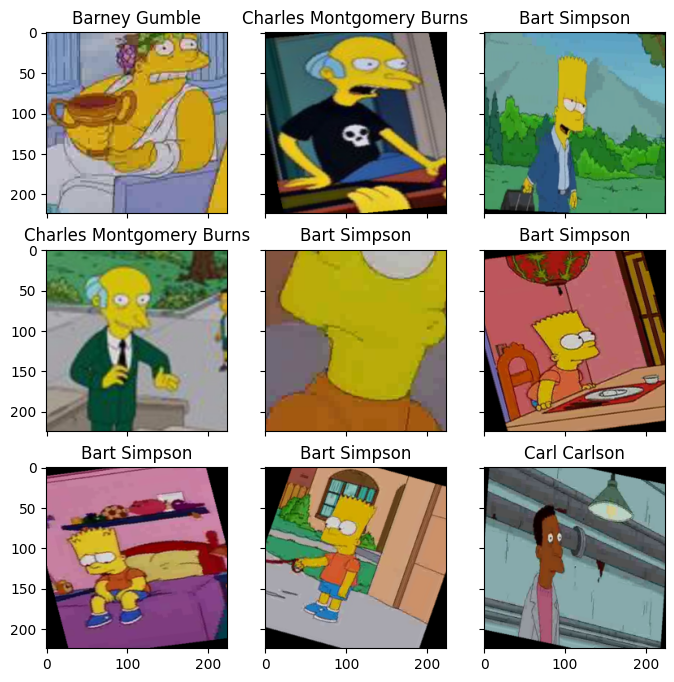

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Решение проблемы с несбалансированными классами - WeightedRandomSampler

In [ ]:
import pandas as pd
count_class = pd.Series(train_val_labels).value_counts()

In [ ]:
sample_weights = 1 /count_class

In [ ]:
count_weights = {k: 1/v for k,v in count_class.items()}
sample_weights = [count_weights[label] for label in train_dataset.labels]

Спизжено

In [ ]:
from torch.utils.data import WeightedRandomSampler
N = int(np.mean(count_class) * len(count_weights))
# N = 10000
print(N)
sampler = WeightedRandomSampler(weights= sample_weights, num_samples= N , replacement= True)

20933


## Testing some neural network

AlexNet

In [ ]:
class MyAlexNet(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(kernel_size= 11, stride= 4, in_channels = 3, out_channels= 96),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(kernel_size= 5, padding= 2, in_channels= 96, out_channels= 256),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 3, stride= 2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(kernel_size= 3, in_channels= 256,  padding= 1, out_channels= 384),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(kernel_size= 3, in_channels= 384,  padding= 1, out_channels= 384),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(kernel_size= 3, in_channels= 384,  padding= 1, out_channels= 256),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 3, stride= 2)
    )
    self.fc_layer1 = nn.Sequential(
        nn.Dropout(p = 0.3),
        nn.BatchNorm1d(6400),
        nn.Linear(in_features= 6400, out_features= 4096), #9216
        nn.ReLU()
    )
    self.fc_layer2 = nn.Sequential(
        nn.Dropout(p = 0.3),
        nn.BatchNorm1d(4096),
        nn.Linear(in_features= 4096, out_features= 1000),
        nn.ReLU()
    )
    self.fc_layer3 = nn.Sequential(
        nn.BatchNorm1d(1000),
        # nn.Dropout(p = 0.3),
        nn.Linear(in_features= 1000, out_features= n_classes)
    )

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = x.reshape(x.size(0), -1)
      x = self.fc_layer1(x)
      x = self.fc_layer2(x)
      x = self.fc_layer3(x)
      return x

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

Net from Caggle notebook

## Neural network traning

In [ ]:
# val_dataset = SimpsonsDataset(val_files, mode='val')
# train_dataset = SimpsonsDataset(val_files, mode='train')
n_classes = len(np.unique(train_val_labels))

In [ ]:
val_dataset[0]

In [ ]:
my_alex_net = MyAlexNet(n_classes).to(DEVICE)
# my_alex_net= MyAlexNet_withBatchNorm(n_classes).to(DEVICE)
# simple_net = SimpleCNN(n_classes).to(DEVICE)

Попробовать подобрать параметры для оптимизатора и лоссфункции. Поиграться другие

In [ ]:
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
def fit(model, max_epoch, lr, batch_size):
    train_losses = []
    valid_losses = []
    accuracy = {'train': [], 'val': []}
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-4, end_factor=1e-5, total_iters = max_epoch)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.85 ** epoch)

    train_dataloader = DataLoader(train_dataset, sampler= sampler, batch_size= batch_size, num_workers= 2)
    test_dataloader = DataLoader(val_dataset,batch_size= batch_size, shuffle = False, num_workers= 2)
    loaders = {'train': train_dataloader, 'val': test_dataloader}

    for epoch in range(max_epoch):
        loss_sum_train = 0
        loss_sum_valid = 0
        for mode, dataloader in loaders.items():

            correct = 0
            processed_data = 0
            for x_batch, y_batch in tqdm(dataloader):
                if mode == 'train':
                  model.train()
                  x_batch = x_batch.to(DEVICE)
                  y_batch = y_batch.to(DEVICE)
                  optimizer.zero_grad()
                  outp = model(x_batch)
                  loss = criterion(outp, y_batch)

                  loss_sum_train += loss.item()

                  loss.backward()
                  optimizer.step()
                else:
                  model.eval()
                  with torch.no_grad():
                    x_batch = x_batch.to(DEVICE)
                    y_batch = y_batch.to(DEVICE)
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss_sum_valid += loss.item()

                preds = torch.argmax(outp, 1)

                correct += torch.sum(preds == y_batch.data)
                processed_data += x_batch.size(0)
            if mode == 'train':
              before_lr = optimizer.param_groups[0]["lr"]
              scheduler.step()
              after_lr = optimizer.param_groups[0]["lr"]
              print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

            if mode == "train":
              print(f"Epoch: {epoch+1}")
              train_losses.append(loss_sum_train / len(dataloader))
              print(f"Loader: {mode}. Accuracy: {correct/processed_data}, Loss: {loss_sum_train / len(dataloader)}")
            else:
              valid_losses.append(loss_sum_valid / len(dataloader))
              print(f"Loader: {mode}. Accuracy: {correct/processed_data}, Loss: {loss_sum_valid / len(dataloader)}")
            accuracy[mode].append(correct/processed_data)

    return accuracy, train_losses, valid_losses

In [ ]:
print(my_alex_net)

In [ ]:
batch_sizes = [128]
lr_array = [1e-4, 1e-5]
max_epoch_for_test = 4

In [ ]:
def test_params(model, batch_sizes, lr_array):
  result = {}
  for batch_size in batch_sizes:
    for lr in lr_array:
      model_temp = MyAlexNet(n_classes).to(DEVICE)
      result[(batch_size, lr)] = fit(model_temp, max_epoch_for_test, lr, batch_size)
      torch.cuda.empty_cache()
  return result

In [ ]:
result = test_params(my_alex_net, batch_sizes, lr_array)

In [ ]:
all_res = list(result.items())
best_solution = [(res[0], res[1][0]['val'][-1]) for res in all_res]
ans = sorted(best_solution, key = lambda x: x[1])[-1]
for res in all_res:
  print(f"Batch_size: {res[0][0]}, lr: {res[0][1]} --- Result= Accuracy_val:{res[1][0]['val'][-1]}, Accuracy_train:{res[1][0]['train'][-1]}, Loss_val: {res[1][2][-1]}")
print()
print('Best solution')
print(f"Batch_size: {ans[0][0]}, lr: {ans[0][1]} --- Result= Accuracy:{ans[1]}")

AlexNet c BatchNorm на каждом слое. Результат перебора параметров

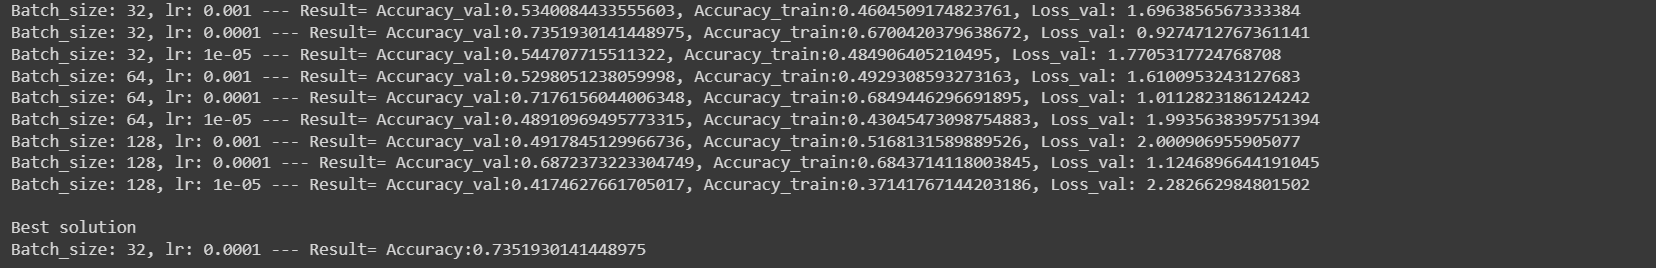

In [ ]:
batch_size = 64
# batch_size = 256
lr_result = 1e-4
max_epoch = 15
my_alex_net_ = MyAlexNet(n_classes).to(DEVICE)

In [ ]:
accuracy, train_losses, valid_losses = fit(my_alex_net_, max_epoch, lr = lr_result, batch_size = batch_size)

100%|██████████| 328/328 [01:30<00:00,  3.61it/s]


Epoch 0: SGD lr 0.000100 -> 0.000085
Epoch: 1
Loader: train. Accuracy: 0.14431758224964142, Loss: 3.2471106110549552


100%|██████████| 82/82 [00:20<00:00,  3.98it/s]


Loader: val. Accuracy: 0.1771111935377121, Loss: 3.3816601619487856


100%|██████████| 328/328 [01:25<00:00,  3.81it/s]


Epoch 1: SGD lr 0.000085 -> 0.000072
Epoch: 2
Loader: train. Accuracy: 0.45468875765800476, Loss: 2.051430965705616


100%|██████████| 82/82 [00:22<00:00,  3.66it/s]


Loader: val. Accuracy: 0.34103935956954956, Loss: 2.3603834233632903


100%|██████████| 328/328 [01:25<00:00,  3.82it/s]


Epoch 2: SGD lr 0.000072 -> 0.000061
Epoch: 3
Loader: train. Accuracy: 0.6104714870452881, Loss: 1.4605501077887488


100%|██████████| 82/82 [00:20<00:00,  3.95it/s]


Loader: val. Accuracy: 0.44325563311576843, Loss: 1.994027374721155


100%|██████████| 328/328 [01:28<00:00,  3.69it/s]


Epoch 3: SGD lr 0.000061 -> 0.000052
Epoch: 4
Loader: train. Accuracy: 0.6947880983352661, Loss: 1.135779183357954


100%|██████████| 82/82 [00:21<00:00,  3.88it/s]


Loader: val. Accuracy: 0.5307604074478149, Loss: 1.6721901770045118


100%|██████████| 328/328 [01:26<00:00,  3.79it/s]


Epoch 4: SGD lr 0.000052 -> 0.000044
Epoch: 5
Loader: train. Accuracy: 0.747336745262146, Loss: 0.9400334923369128


100%|██████████| 82/82 [00:22<00:00,  3.67it/s]


Loader: val. Accuracy: 0.5781429409980774, Loss: 1.4919911266827002


100%|██████████| 328/328 [01:27<00:00,  3.74it/s]


Epoch 5: SGD lr 0.000044 -> 0.000038
Epoch: 6
Loader: train. Accuracy: 0.7759040594100952, Loss: 0.8328912006463947


100%|██████████| 82/82 [00:22<00:00,  3.66it/s]


Loader: val. Accuracy: 0.6131066083908081, Loss: 1.3985627613416531


100%|██████████| 328/328 [01:28<00:00,  3.72it/s]


Epoch 6: SGD lr 0.000038 -> 0.000032
Epoch: 7
Loader: train. Accuracy: 0.8018917441368103, Loss: 0.7239520207853851


100%|██████████| 82/82 [00:20<00:00,  3.92it/s]


Loader: val. Accuracy: 0.6398547887802124, Loss: 1.3209567208115647


100%|██████████| 328/328 [01:26<00:00,  3.77it/s]


Epoch 7: SGD lr 0.000032 -> 0.000027
Epoch: 8
Loader: train. Accuracy: 0.8181818127632141, Loss: 0.6683447562703272


100%|██████████| 82/82 [00:21<00:00,  3.84it/s]


Loader: val. Accuracy: 0.6505540609359741, Loss: 1.2526186014094003


100%|██████████| 328/328 [01:25<00:00,  3.82it/s]


Epoch 8: SGD lr 0.000027 -> 0.000023
Epoch: 9
Loader: train. Accuracy: 0.8314622640609741, Loss: 0.6194509934724831


100%|██████████| 82/82 [00:22<00:00,  3.71it/s]


Loader: val. Accuracy: 0.6648834943771362, Loss: 1.2225869443358444


100%|██████████| 328/328 [01:26<00:00,  3.81it/s]


Epoch 9: SGD lr 0.000023 -> 0.000020
Epoch: 10
Loader: train. Accuracy: 0.8423541784286499, Loss: 0.5835381149791363


100%|██████████| 82/82 [00:20<00:00,  3.96it/s]


Loader: val. Accuracy: 0.6729079484939575, Loss: 1.1978962156103878


100%|██████████| 328/328 [01:26<00:00,  3.77it/s]


Epoch 10: SGD lr 0.000020 -> 0.000017
Epoch: 11
Loader: train. Accuracy: 0.8478478789329529, Loss: 0.5505045615420563


100%|██████████| 82/82 [00:21<00:00,  3.79it/s]


Loader: val. Accuracy: 0.6895300149917603, Loss: 1.1586160779726216


100%|██████████| 328/328 [01:26<00:00,  3.78it/s]


Epoch 11: SGD lr 0.000017 -> 0.000014
Epoch: 12
Loader: train. Accuracy: 0.8602684736251831, Loss: 0.5089317767244832


100%|██████████| 82/82 [00:22<00:00,  3.68it/s]


Loader: val. Accuracy: 0.700229287147522, Loss: 1.1295572446613777


100%|██████████| 328/328 [01:26<00:00,  3.79it/s]


Epoch 12: SGD lr 0.000014 -> 0.000012
Epoch: 13
Loader: train. Accuracy: 0.8701093792915344, Loss: 0.4840212403001582


100%|██████████| 82/82 [00:20<00:00,  3.96it/s]


Loader: val. Accuracy: 0.6948796510696411, Loss: 1.1648607628374565


100%|██████████| 328/328 [01:29<00:00,  3.65it/s]


Epoch 13: SGD lr 0.000012 -> 0.000010
Epoch: 14
Loader: train. Accuracy: 0.8746476769447327, Loss: 0.4546747561089876


100%|██████████| 82/82 [00:21<00:00,  3.88it/s]


Loader: val. Accuracy: 0.700611412525177, Loss: 1.0984088534989007


100%|██████████| 328/328 [01:26<00:00,  3.79it/s]


Epoch 14: SGD lr 0.000010 -> 0.000009
Epoch: 15
Loader: train. Accuracy: 0.8758419752120972, Loss: 0.45029565726020715


100%|██████████| 82/82 [00:22<00:00,  3.69it/s]

Loader: val. Accuracy: 0.7072984576225281, Loss: 1.0927983580566034


In [ ]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outp = model(inputs).cpu()
      logits.append(outp)

  preds = nn.functional.softmax(torch.cat(logits), dim = -1).numpy()

  return preds

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
probs = predict(my_alex_net_, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/MyDrive/MyAlexNet_5Normis.csv', index=False)

In [ ]:
torch.cuda.empty_cache()